# Apresentação ✒️


Notebook destinado ao estudo e implementação de advanced retrieval com Chroma, um framework que permite a criação de banco de dados vetorial, capaz de prover recuperação de inforamação, a partir de uma consulta do usuário, com base na similaridade vetorial.

Advanced retrieval se circunscreve no escopo da técnica conhecida como Retrieval Argumentend Generation (RAG), na qual determina ao modelo de LLM realizar uma consulta em conjunto previamente armazenadas ou buscadas, como forma de produzir uma resposta mais assertiva e apurada.

Não obstante, apesar de sua relevância para aplicações que envolvem IA's generativas, a sua eficiência encontra alguns desafios, principalmente associados na recuperação de informações com base na consulta do usuário que, além de possuírem similaridade vetorial, possuam também relevância.

Ao longo do notebook será exposto um cenário no qual é possível observar que apenas a similaridade vetorial não garante sempre que os melhores dados sejam recuperados e, assim, possa ao modelo oferecer uma resposta efetiva ao usuário, motivando a implementação de outras técnicas, como *expansive query* e *crossencoder - rerank*.

Expansive query se refere ao processo no qual informamos ao modelo de LLM a consulta do usuário e a partir dessa pedimos que ele gere uma possível resposta ou enumere algumas perguntas, que possam melhor delimitar o campo de busca dos dados.

Por outro lado, o crossencoder - rerank se trata de uma combinação de técnicas entre um crossencoder com rerank, o processo de rankeamento dos dados trazidos com base em sua maior relevância, auferida pela menor distância vetorial entre os dados.

Nesse cenário, o crossencoder já é desempenhado pela implementação da expansive query, que irá realizar a extração primária de informação a partir do conjunto dos dados totais, enquanto que o rerank será a segunda extração da informação, que irá considerar apenas os itens mais relevantes do universo pré-selecionado.

Para esse estudo, o arquivo que servirá como caso de uso será um artigo da Microsoft, acerca de um reporte financeiro de 2022. O objetivo será demonstrar a eficiência de cada técnica de advanced retrieval, comparando-a com uma recuperação de baseline na qual utiliza-se apenas a similaridade vetorial como ferramenta de procura. Além disso, para a sua elaboração, irei passar por tópicos importantes ao processo da criação do banco de dados, inclusive do load do conjunto de dados e sua divisão, para que possa tornar a procura de informação mais eficiente.

## Biblioteca 📚

In [1]:
!pip install langchain -q

!pip install langchain_community -q

!pip install langchain_google_genai -q

!pip install chromadb -q

!pip install google_generative_ai -q

!pip install pypdf -q

!pip install sentence_transformers -q

!pip install umap-learn -q

ERROR: Could not find a version that satisfies the requirement google_generative_ai (from versions: none)
ERROR: No matching distribution found for google_generative_ai


In [2]:
import os
import umap.umap_ as umap
import numpy as np
import chromadb
import google.generativeai as genai
import matplotlib.pyplot as plt

from langchain.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

from langchain_google_genai import ChatGoogleGenerativeAI

from langchain import PromptTemplate
from langchain.chains import LLMChain

from pypdf import PdfReader

from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

from sentence_transformers import CrossEncoder

from tqdm import tqdm

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Definindo as variáveis de ambiente

In [4]:
os.environ["GOOGLE_API_KEY"] = ""

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

## Definindo o modelo de LLM de uso

In [5]:
llm = ChatGoogleGenerativeAI(
    model = "gemini-1.5-pro-latest",
    temperature=0.2
)

## Carregando o conjunto de dados 💾

In [6]:
file_path = "/content/microsoft_annual_report_2022.pdf"
reader = PdfReader(file_path)


pdf_text = [p.extract_text() for p in reader.pages]

# Filtrando strings vazias para que apenas retornem texto.

pdf_text = [text for text in pdf_text if text]

In [7]:
# Visualizando a quantidade de páginas do arquivo :

len(pdf_text)

92

In [8]:
# Visualizando um trecho do texto recuperado :

pdf_text[1]

'1 Dear shareholders, colleagues, customers, and partners:  \nWe are living through a period of historic economic, societal, and geopolitical change. The world in 2022 looks nothing like \nthe world in 2019. As I write this, inflation is at a 40 -year high, supply chains are stretched, and the war in Ukraine is \nongoing. At the same time, we are entering a technological era with the potential to power awesome advancements \nacross every sector of our economy and society. As the world’s largest software company, this places us at a historic \nintersection of opportunity and responsibility to the world around us.  \nOur mission to empower every person and every organization on the planet to achieve more has never been more \nurgent or more necessary. For all the uncertainty in the world, one thing is clear: People and organizations in every \nindustry are increasingly looking to digital technology to overcome today’s challenges and emerge stronger. And no \ncompany is better positioned 

## Dividindo o texto

Antes do texto passar pelo processo de embedding e ser enviado a um banco de dados vetorial (vector db), faz-se necessário que o esse seja dividido em menores partes, buscando a otimização durante o processo de recuperação da informação armazenada com base na consulta do usuário.

Desse modo, essa etapa perpassa duas etapas de divisão, a primeira realizada por meio de um divisor por caractere recursivo, que irá realizar a segmentação contabilizando o arquivo como um todo, e a segunda, que irá realizar uma divisão por tokens, como forma de criar porções semânticamente relevantes.

Para saber mais : https://medium.com/@hadiazouni/text-splitting-chunking-for-rag-applications-7ccbb6dcc9f9



In [9]:
# Divisão por caractere

recursive_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 2000,
    chunk_overlap = 150,
    length_function = len,
    separators=['\n\n', '\n', '.', ' ', '']
)

text_splitted_rc = recursive_splitter.split_text('\n\n'.join(pdf_text))


In [10]:
print(f'Quantidade de partes geradas após a primeira divisão : {len(text_splitted_rc)}')


Quantidade de partes geradas após a primeira divisão : 199


In [11]:
# Segunda divisão por tokens.

token_splitter = SentenceTransformersTokenTextSplitter(
    tokens_per_chunk=256,
    chunk_overlap=0
)

In [12]:
token_split_text = []

for text in text_splitted_rc:

  token_split_text += token_splitter.split_text(text)

In [13]:
print(f'Quantidade de partes geradas após a segunda divisão : {len(token_split_text)}')


Quantidade de partes geradas após a segunda divisão : 337


## Instanciando o modelo de embedding

O modelo de embedding se refere ao algoritmo que transforma elementos de linguagem natural em uma representação vetorial. A sua importância reside no fato de que apenas desse modo consegue-se armazenar dados em um espaço vetorial, como um vector db.

In [14]:
# Dados transformados de linguagem natural para uma representação vetorial,
# por meio de embedding habilita que sejam que esses banco de dados vetorial
# para serem consultados posteriormente.

embedding_function = SentenceTransformerEmbeddingFunction()

In [15]:
# Criando o banco de dados vetorial. O banco de dados escolhido
# é o Chroma, um framework open source que habilita a criação
# desses bancos para uso.

# Criando o objeto chroma_client, que me permitirá interagir com o ChromaDB.

chroma_client = chromadb.Client()

# Criando o banco de dados vetorial. Para isso, define-se seu nome e o modelo
# de embedding de uso.

chroma_db = chroma_client.create_collection(name = "microsoft_anual_report",
                                            embedding_function = embedding_function)


In [16]:
# Gerando uma lista de identificação para cada porção
# presente no meu banco de dados vetorial.

ids = [str(i) for i in range(len(token_split_text))]


In [17]:
# Adicionando os documentos ao banco de dados vetorial
# junto de cada identificação.

chroma_db.add(ids=ids, documents=token_split_text)


In [18]:

# Verificando a quantidade de itens no banco de dados vetorial.

chroma_db.count()

337

##Realizando a consulta da informação

Nessa etapa irei demonstrar uma abordagem de consulta do tipo padrão, sem utilizar-se de técnicas que visam a eficiência da recuperação e outra que utiliza-se dessas, que será uma combinação de expansive query com cross-encoder re-rank.

### Busca padrão (baseline)

In [19]:
"""
Para visualizar o impacto que as técnicas de recuperação avançada
representam no instante da consulta do usuário, irei criar um gráfico
de dispersão em duas dimensões. Nele, estará dispostos os vetores
(representados por círculos) que representam os dados armazenados, bem
como o elemento de consulta, representado por x, e os vetores que seriam
mais relevantes a essa, representados por um contorno circular verde nos vetores.
"""

# Para criar esse gráfico, antes precisarei realizar a transformação
# dimensional do vector db.

# Extraindo os embeddings do vector db :

embeddings = chroma_db.get(include=['embeddings'])["embeddings"]

# Ajustando o modelo de transformação dimensional aos embeddings presentes :

umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

In [20]:
# Criando a função que irá realizar a representação gráfica do vector db

def visualize_vector_db(embeddings, umap_transform):

  # Criando um array vazio para armazenar os embeddings representados.

  umap_embeddings = np.empty((len(embeddings), 2))

  # Realizando a transformação dimensional dos embeddings

  for i, embedding in enumerate(tqdm(embeddings)):

    umap_embeddings[i] = umap_transform.transform([embedding])

  return umap_embeddings

In [21]:

vector_db_graph = visualize_vector_db(embeddings, umap_transform)

100%|██████████| 337/337 [05:54<00:00,  1.05s/it]


(-3.7558590888977053, 7.321249675750733, 6.518512153625489, 12.525673484802246)

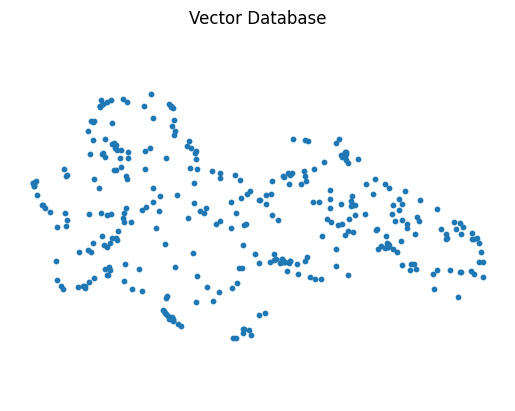

In [22]:
# Para visualizar graficamente :

plt.figure()
plt.scatter(vector_db_graph[:, 0], vector_db_graph[:, 1], s = 10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Vector Database')
plt.axis('off')

### Realizando a consulta



In [23]:
# Realizando a consulta e verificando a sua eficiência
# a partir da visualização do gráfico do vector db.

query = "What they are the thoughts about AI in this article ?"

retrieve = chroma_db.query(query_texts=[query], n_results=5, include=["documents", "embeddings"])

retrieved_documents = retrieve["documents"][0]

In [24]:
# com base na consulta realizada.

retrieved_documents[:2]

['4 our commitment to responsibly develop and use technologies like ai is core to who we are. we put our commitment into practice, not only within microsoft but by empowering our customers and partners to do the same and by advocating for policy change. we released our responsible ai standard, which outlines 17 goals aligned to our six ai principles and includes tools and practices to support them. and we share our open - source tools, including the new responsible ai dashboard, to help developers building ai technologies identify and mitigate issues before deployment. finally, we provide clear reporting and information on how we run our business and how we work with customers and partners, delivering the transparency that is central to trust. our annual impact summary shares more about our progress and learnings across these four commitments, and our reports hub provides detailed reports on our environmental data, our political activities, our workforce demographics, our human rights 

### Visualizando a eficiência da recuperação

In [25]:
query_embedding = embedding_function(query)[0]

retrieved_embedding = retrieve["embeddings"][0]

visualize_query_embedding = visualize_vector_db([query_embedding],
                                                umap_transform)

visualize_retrieved_embedding = visualize_vector_db(retrieved_embedding,
                                                    umap_transform)

100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


(-3.7558590888977053, 7.321249675750733, 6.518512153625489, 12.525673484802246)

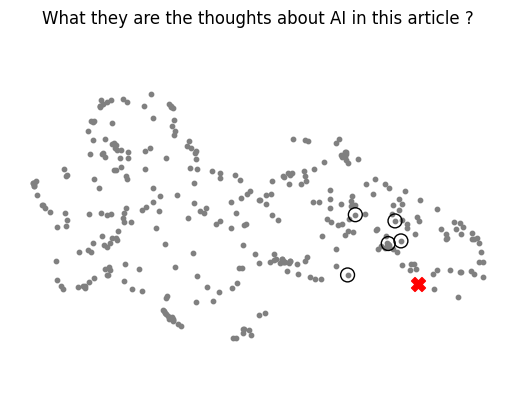

In [26]:
# Realizando a visualização gráfica :

plt.figure()
plt.scatter(vector_db_graph[:, 0], vector_db_graph[:, 1], s = 10, color = 'gray')

plt.scatter(visualize_query_embedding[:, 0], visualize_query_embedding[:, 1],
            s = 100, marker = 'X', color = 'r')

plt.scatter(visualize_retrieved_embedding[:, 0], visualize_retrieved_embedding[:, 1],
            s = 100, facecolors = 'none', edgecolors = 'black')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

O gráfico acima busca informar como ocorre a recuperação da informação no banco de dados vetorial, utilizando-se apenas da consulta e da sua similaridade vetorial com os elementos nesse presentes.

Nota-se que os dados escolhidos distam dos vetores que possuiriam maior relevância para responder a query informada. Na marcação do X, em vermelho, está os vetores selecionados, enquanto que os mais relevantes são circulados por um contorno em preto.

## Implementando a busca com expansive query mais cross-encoder re-rank

Essa implementação é seguida por duas principais etapas. A primeira configura-se na primeira recuperação dos dados, com base na consulta informada, enquanto que a segunda se define por ser uma etapa da seleção do conteúdo mais relevante dos documentos previamente selecionados.

No presente cenário, estou combinando essa abordagem com a técnica conhecida como query expansive (expansão da consulta) a partir da qual busco fornecer mais contexto para a pesquisa, buscando promover uma delimitação maior do campo de busca, que somente a query poderia deixar a desejar.

Para a realização da recuperação da informação utiliza-se por padrão o ângulo encontrado pelo cosseno, para avaliar a similaridade vetorial entre o elemento de consulta e os dados presentes no banco de dados vetorial. Não obstante, na segunda etapa de seleção, desempenhada pelo cross-encoder essa técnica também é utilizada, mas em conjunto de consulta e elementos a serem recuperados, realizando uma pontuação para cada qual. Aqueles que apresentam melhores pontuações são tidos como mais relevantes, enquanto os que apresentam o oposto são tidos como menos relevantes.

## Primeira etapa : extração da informação com expasive query

In [27]:
def argument_multiple_query(query, model = llm):

  template = PromptTemplate(
      input_variables=["query"],
      template="""
      You are an experienced and efficient generative AI developer.
      Suggest up to ten additional related questions to help them find the information they need, for the provided question.
      Suggest only short questions without compound sentences.
      Suggest a variety of questions that cover different aspects of the topic.
      Make sure they are complete questions, and that they are related to the original question.
      Output one question per line. Do not number the questions.

      Question : {query}

      Helpful Answer : """  )

  chain = LLMChain(llm=model, prompt=template)
  response = chain.run(query=query)

  return response

In [28]:
original_query = "What the articles talks about artificial intelligence (AI) ?"

argumented_multiple_query_output = argument_multiple_query(original_query)

In [29]:
# Visualizando as múltiplas perguntas realizadas pelo modelo :

argumented_multiple_query_output

'What is the main focus of the AI articles?\nWhat types of AI are discussed?\nWhat are the benefits of AI according to the articles?\nWhat are the risks or challenges of AI?\nAre there any ethical concerns raised about AI?\nHow is AI being used in specific industries?\nWhat is the future of AI?\nWho are the key players in the field of AI?\nWhat are some real-world examples of AI applications?\nWhere can I find more information about AI? \n'

In [30]:
# Realizando a pesquisa no banco de dados vetorial, junto
# da expansive query, combinando a consulta original com as
# perguntas geradas pelo modelo de LLM.

queries = f'{original_query}  {argumented_multiple_query_output}'
results = chroma_db.query(query_texts=queries, n_results=10, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]


In [31]:
# Visualizando alguns dos trechos recuprados.

retrieved_documents[:2]

['to customers. we are building a distributed computing fabric – across cloud and the edge – to help every organization build, run, and manage mission - critical workloads anywhere. in the next phase of innovation, artificial intelligence ( “ ai ” ) capabilities are rapidly advancing, fueled by data and knowledge of the world. we are enabling metaverse experiences at all layers of our stack, so customers can more effectively model, automate, simulate, and predict changes within their industrial',
 'across our end - user experiences and devices, including office, windows, teams, consumer web experiences ( including search and news advertising ), and the surface line of devices. • security, compliance, identity, and management, focuses on cloud platform and application security, identity and network access, enterprise mobility, information protection, and managed services. • technology and research, focuses on our ai innovations and other forward - looking research and']

In [32]:
# Visualiando a melhora no campo de busca com a utilização
# da expansion query :

retrieved_embedding = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
argument_query_embedding = embedding_function([argumented_multiple_query_output])

visualize_original_query_embedding = visualize_vector_db(original_query_embedding, umap_transform)
visualize_argument_query_embedding = visualize_vector_db(argument_query_embedding, umap_transform)
visualize_retrieved_embedding = visualize_vector_db(retrieved_embedding, umap_transform)


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


(-3.7558590888977053, 7.321249675750733, 6.518512153625489, 12.525673484802246)

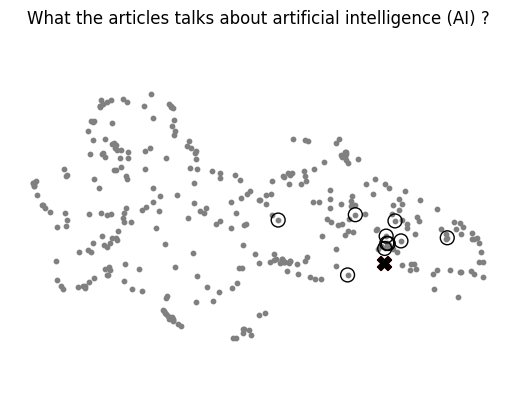

In [33]:
# Visualizando o campo de busca gerado com a expansive query.

plt.figure()

plt.scatter(vector_db_graph[:, 0], vector_db_graph[:, 1], s = 10, color = 'gray')

plt.scatter(visualize_original_query_embedding[:, 0], visualize_original_query_embedding[:, 1],
            s = 100, marker = 'X', color = 'red')

plt.scatter(visualize_argument_query_embedding[:, 0], visualize_argument_query_embedding[:, 1],
            s = 100, marker = 'X', color = 'black')

plt.scatter(visualize_retrieved_embedding[:, 0], visualize_retrieved_embedding[:, 1],
            s = 100, facecolors = 'none', edgecolors = 'black')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

A partir da técnica de expansive query utilizada, nota-se que a recuperação dos dados se tornou mais próxima dos dados mais relevantes, em comparação com a recuperação de baseline, na qual essa distava muito dos dados.

## Segunda etapa da extração : crossencoder re-rank

In [34]:
# Instanciando o modelo de cross-encoder para a realização
# da segunda etapa de seleção dos documentos mais relevantes
# à consulta do usuário.

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [35]:
# Formando o par consulta e documentos.

pairs = [[query, doc] for doc in retrieved_documents]

# Obtendo a pontuação dos documentos, com base na consulta.
# Aqueles que apresentam a melhor pontuação são aqueles que
# são tidos como mais relevantes em responder a consulta.

scores = cross_encoder.predict(pairs)

In [36]:
# Etapa 4: Ordenando os documentos com base nos scores obtidos

documents_with_scores = list(zip(retrieved_documents, scores))

In [37]:
# Visualizando alguns dos documentos extraídos
# na primeira etapa com a sua respectiva pontuação.

documents_with_scores[:2]

[('to customers. we are building a distributed computing fabric – across cloud and the edge – to help every organization build, run, and manage mission - critical workloads anywhere. in the next phase of innovation, artificial intelligence ( “ ai ” ) capabilities are rapidly advancing, fueled by data and knowledge of the world. we are enabling metaverse experiences at all layers of our stack, so customers can more effectively model, automate, simulate, and predict changes within their industrial',
  -3.3833141),
 ('across our end - user experiences and devices, including office, windows, teams, consumer web experiences ( including search and news advertising ), and the surface line of devices. • security, compliance, identity, and management, focuses on cloud platform and application security, identity and network access, enterprise mobility, information protection, and managed services. • technology and research, focuses on our ai innovations and other forward - looking research and',

In [38]:
# Reordenando os documentos, com base em sua pontuação.
# Aqueles que apresentam maior pontuação são tidos como mais relevantes.

ranked_documents = sorted(documents_with_scores, key=lambda x: x[1], reverse=True)

In [39]:
# Visualizando os documentos reordenados :

ranked_documents

[('to customers. we are building a distributed computing fabric – across cloud and the edge – to help every organization build, run, and manage mission - critical workloads anywhere. in the next phase of innovation, artificial intelligence ( “ ai ” ) capabilities are rapidly advancing, fueled by data and knowledge of the world. we are enabling metaverse experiences at all layers of our stack, so customers can more effectively model, automate, simulate, and predict changes within their industrial',
  -3.3833141),
 ('4 our commitment to responsibly develop and use technologies like ai is core to who we are. we put our commitment into practice, not only within microsoft but by empowering our customers and partners to do the same and by advocating for policy change. we released our responsible ai standard, which outlines 17 goals aligned to our six ai principles and includes tools and practices to support them. and we share our open - source tools, including the new responsible ai dashboar

In [40]:
# Extraindo os 5 documentos mais relevantes, com base na consulta do usuário,
# com base na reordenação anteriormente realizada.

top5_re_ranked_documents = [doc for doc, score in ranked_documents[:5]]

In [47]:
# Visualizando os documentos melhor rankeados.

top5_re_ranked_documents[:5]

['to customers. we are building a distributed computing fabric – across cloud and the edge – to help every organization build, run, and manage mission - critical workloads anywhere. in the next phase of innovation, artificial intelligence ( “ ai ” ) capabilities are rapidly advancing, fueled by data and knowledge of the world. we are enabling metaverse experiences at all layers of our stack, so customers can more effectively model, automate, simulate, and predict changes within their industrial',
 '4 our commitment to responsibly develop and use technologies like ai is core to who we are. we put our commitment into practice, not only within microsoft but by empowering our customers and partners to do the same and by advocating for policy change. we released our responsible ai standard, which outlines 17 goals aligned to our six ai principles and includes tools and practices to support them. and we share our open - source tools, including the new responsible ai dashboard, to help develo

## Realizando a técnica RAG com os melhores documentos selecionados

In [49]:
def rag(query, retrieved_documents, model = llm):

  information = '\n\n'.join(retrieved_documents)

  prompt_template = PromptTemplate(
      input_variables = ["query", "information"],
      template = ("""
      You are an experienced and efficient generative AI developer.
      You need to respond in a clear and informative way to the user's query
      on the topic of AI agents. You will be presented with the user query
      and the relevant parts of an article that talks about the topic.
      Answer the user's question using only the information presented to you.

      Question : {query}
      Information : {information}

      Helpful Answer :
      """)
  )

  chain = LLMChain(llm = llm, prompt = prompt_template)

  response = chain.run(query = query,
                       information = information)

  return response

In [50]:
bot = rag(original_query, top5_re_ranked_documents)

In [51]:
print(bot)

This article discusses artificial intelligence (AI) in the context of its rapid advancement and its role in the next phase of technological innovation. 

Here are some key points from the article:

* **AI's growing importance:** AI is developing rapidly, driven by data and knowledge, and is becoming crucial for businesses to model, automate, simulate, and predict changes.
* **Microsoft's role in AI:** Microsoft is committed to responsibly developing and using AI, providing tools and resources for its ethical implementation. They are also investing in AI research and development, particularly in areas like infrastructure, services, and applications.
* **AI in specific sectors:** The article highlights the use of AI in healthcare through the acquisition of Nuance, an AI software provider. This acquisition aims to enhance Microsoft's industry-specific cloud offerings. 

The article emphasizes the significance of AI across various applications and Microsoft's dedication to its responsible 